## Bootcamp Amazing Data Intelligence - F1 Drivers

### Introdução

Este notebook foi criado por Eduardo Rodrigues Sigarini para o Bootcamp Amazing Data Intelligence do MBA em Engenharia e Ciência de Dados da UNIESP e tem como objetivo analisar o histórico de pilotos da F1, combinando métricas de desempenho (títulos, vitórias, pódios, poles, pontos) com informações sobre acidentes fatais na categoria.

Ao longo da análise, vamos responder a perguntas como:

- Quais pilotos acumularam mais títulos, vitórias, pódios e poles na F1?
- Como os pilotos campeões se comparam em termos de **taxa de vitória** e **taxa de pódio** por largada?
- Qual é o desempenho dos pilotos brasileiros na categoria em participações e pódios?
- Quais equipes e circuitos aparecem com mais acidentes na história?
- Em que tipo de evento (corrida, treino, teste, classificação, demonstração) ocorreram mais acidentes?

#### Sobre o dataset

A base utilizada foi construida a partir de umtratamento inicial no Pentaho, combinando dois datasets principais: o [Formula 1 Race Events do Kaggle](https://www.kaggle.com/datasets/jtrotman/formula-1-race-events) e um dataset extraído da lista de pilotos de Fórmula 1 disponível na [Wikipedia](https://en.wikipedia.org/wiki/List_of_Formula_One_drivers) (essa lista está atualizada até o Grande Prêmio de Las Vegas de 2025. Pilotos que participaram apenas de treinos de sexta-feira e não foram oficialmente inscritos na corrida não estão incluídos).

Após o tratamento e a junção desses dois conjuntos de dados, foi possível reunir informações consolidadas sobre pilotos de Fórmula 1, incluindo:

* Dados de carreira: títulos, vitórias, pódios, pole positions, voltas rápidas, pontos, largadas, temporadas e taxas derivadas.
* Dados de acidentes: idade, data, circuito, equipe e tipo de evento (corrida, treino, teste, classificação, demonstração etc.), quando disponíveis.

Importante: os dados de desempenho são consolidados por carreira (e não detalhados por temporada), o que impacta alguns recortes temporais e comparações ao longo do tempo na análise.

### Importação de bibliotecas e carregamento dos dados

In [1]:
# Bibliotecas principais para análise de dados e visualização
import pandas as pd
from pathlib import Path
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações de visualização
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Definição do caminho base e leitura do arquivo tratado
file_path = Path(r'C:\Users\dudur\OneDrive\Desktop\mba_eng_dados\bootcamp_data_intelligence\data\F1DriversTratados.csv')
df = pd.read_csv(file_path)

# Visão geral inicial do dataset
print(df.shape)
df.head()

(882, 25)


,Pilotos,Nacionalidade,Temporadas,Titulos,Participacao,Largadas,Pole_Positions,Vitorias,Podio,Volta_rapida,...,Taxa_podio,Taxa_volta_rapida,Pontos_largadas,Campeao,Pilotos_1,Idade,Data_acidente,Corrida,Equipe,Evento
0,A. J. Foyt,United States ...,"[1958, 1959, 1960] ...",0.00,3.00,3.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,False,...,NaN,...,...,...,...
1,Adolf Brudes,West Germany ...,[1952] ...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,False,...,NaN,...,...,...,...
2,Adolfo Schwelm Cruz,Argentina ...,[1953] ...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,False,...,NaN,...,...,...,...
3,Adrian Sutil,Germany ...,"[2007, 2008, 2009, 2010, 2011, 2013, 2014] ...",0.00,128.00,128.00,0.00,0.00,0.00,1.00,...,0.00,0.01,0.97,False,...,NaN,...,...,...,...
4,Adrián Campos,Spain ...,"[1987, 1988] ...",0.00,21.00,17.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,False,...,NaN,...,...,...,...


### Limpeza e Tratamento dos Dados

In [2]:
# Padronização de textos básicos
colunas_texto = ['Pilotos', 'Nacionalidade', 'Corrida', 'Equipe', 'Evento']

for col in colunas_texto:
    df[col] = df[col].astype(str).str.strip()

# Nacionalidade e Pilotos
df['Nacionalidade'] = (
    df['Nacionalidade']
    .str.replace('\xa0', ' ', regex=True)
    .str.strip()
    .str.title()
)

df['Pilotos'] = df['Pilotos'].str.strip().str.title()


In [3]:
# Tratar Corrida e criar Circuito padronizando o nome

df['Corrida'] = (
    df['Corrida']
    .astype(str)
    .str.replace(r'^\s*\d{4}\s+', '', regex=True)
    .str.strip()
)

df['Circuito'] = df['Corrida'].str.strip().str.title()
df['Circuito'] = df['Circuito'].replace(['', 'N/A', 'NaN', 'nan', 'Nan', 'None'], np.nan)

In [4]:
# Transformar a coluna Temporadas de lista em uma linha por ano

def trata_temporadas(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str) and '[' in x:
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return np.nan
    # se for string vazia, 'nan', etc., vira NaN
    return np.nan

df['Temporadas'] = df['Temporadas'].apply(trata_temporadas)

df_explodido = df.explode('Temporadas').copy()

df_explodido['Temporadas'] = pd.to_numeric(df_explodido['Temporadas'], errors='coerce')

df_explodido['Temporadas'] = df_explodido['Temporadas'].astype('Int64')

# Esse DF vai ser usado para analises que precisam de ano a ano
df_temporadas = df_explodido.reset_index(drop=True)

df_temporadas.head()

,Pilotos,Nacionalidade,Temporadas,Titulos,Participacao,Largadas,Pole_Positions,Vitorias,Podio,Volta_rapida,...,Taxa_volta_rapida,Pontos_largadas,Campeao,Pilotos_1,Idade,Data_acidente,Corrida,Equipe,Evento,Circuito
0,A. J. Foyt,United States,1958,0.00,3.00,3.00,0.00,0.00,0.00,0.00,...,0.00,0.00,False,...,NaN,...,,,,NaN
1,A. J. Foyt,United States,1959,0.00,3.00,3.00,0.00,0.00,0.00,0.00,...,0.00,0.00,False,...,NaN,...,,,,NaN
2,A. J. Foyt,United States,1960,0.00,3.00,3.00,0.00,0.00,0.00,0.00,...,0.00,0.00,False,...,NaN,...,,,,NaN
3,Adolf Brudes,West Germany,1952,0.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,False,...,NaN,...,,,,NaN
4,Adolfo Schwelm Cruz,Argentina,1953,0.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,False,...,NaN,...,,,,NaN


In [5]:
# Preencher NAN com 0 em colunas de métricas numéricas
colunas_metricas = [
    'Titulos', 'Participacao', 'Largadas',
    'Pole_Positions', 'Vitorias', 'Podio',
    'Volta_rapida', 'Pontos'
]

df[colunas_metricas] = df[colunas_metricas].fillna(0)

In [6]:
# Traduzir o nome dos Países da coluna Nacionalidade
map_paises = {
    '': '', 
    'Argentina': 'Argentina',
    'Australia': 'Austrália',
    'Austria': 'Áustria',
    'Belgium': 'Bélgica',
    'Belgium France': 'Bélgica / França',
    'Brazil': 'Brasil',
    'Canada': 'Canadá',
    'Chile': 'Chile',
    'China': 'China',
    'Colombia': 'Colômbia',
    'Czech Republic': 'República Tcheca',
    'Denmark': 'Dinamarca',
    'East Germany': 'Alemanha Oriental',
    'East Germany, West Germany': 'Alemanha Oriental / Ocidental',
    'Finland': 'Finlândia',
    'France': 'França',
    'Germany': 'Alemanha',
    'Hungary': 'Hungria',
    'India': 'Índia',
    'Indonesia': 'Indonésia',
    'Ireland': 'Irlanda',
    'Italy': 'Itália',
    'Japan': 'Japão',
    'Liechtenstein': 'Liechtenstein',
    'Malaysia': 'Malásia',
    'Mexico': 'México',
    'Monaco': 'Mônaco',
    'Monaco Netherlands': 'Mônaco / Países Baixos',
    'Morocco': 'Marrocos',
    'Netherlands': 'Países Baixos',
    'New Zealand': 'Nova Zelândia',
    'Poland': 'Polônia',
    'Portugal': 'Portugal',
    'Raf': 'Rússia (RAF)',
    'Rhodesia': 'Rodésia',
    'Rhodesia And Nyasaland': 'Rodésia e Niassalândia',
    'Russia': 'Rússia',
    'South Africa': 'África do Sul',
    'Spain': 'Espanha',
    'Sweden': 'Suécia',
    'Switzerland': 'Suíça',
    'Thailand': 'Tailândia',
    'United Kingdom': 'Reino Unido',
    'United States': 'Estados Unidos',
    'Uruguay': 'Uruguai',
    'Venezuela': 'Venezuela',
    'West Germany': 'Alemanha Ocidental'
}

df['Nacionalidade_pt'] = df['Nacionalidade'].replace(map_paises)

In [7]:
cols_int = [
    'Titulos', 'Participacao', 'Largadas', 'Pole_Positions',
    'Vitorias', 'Podio', 'Volta_rapida', 'Pontos'
]

df[cols_int] = df[cols_int].apply(
    lambda s: pd.to_numeric(s, errors='coerce')
)

df[cols_int] = df[cols_int].fillna(0)

df[cols_int] = df[cols_int].astype(int)

In [8]:
# Novo DF principal para análise
df_analise = df.copy()

In [9]:
# DF auxiliares para certas analises, como acidentes fatais e Circuitos

df_fatais = df_analise[df_analise['Data_acidente'].notnull()].copy()

df_fatais['Equipe'] = (
    df_fatais['Equipe']
    .astype(str)
    .str.strip()
    .str.title()
)

df_eventos = df_analise.copy()

df_eventos['Evento'] = df_eventos['Evento'].astype(str).str.strip()

df_eventos = df_eventos[~df_eventos['Evento'].isin(['', 'nan', 'NaN'])]

map_eventos = {
    'Race': 'Corrida',
    'Practice': 'Treino livre',
    'Test': 'Teste',
    'Qualifying': 'Classificação',
    'Pre-Race Test': 'Teste pré-corrida',
    'Pre-race test': 'Teste pré-corrida',
    'Demonstration': 'Demonstração'
}

df_eventos['Evento'] = df_eventos['Evento'].replace(map_eventos)

In [10]:
print('df_analise:', df_analise.shape)
print('df_fatais:', df_fatais.shape)
print('df_eventos:', df_eventos.shape)

df_analise.head()

df_analise: (882, 27)
df_fatais: (876, 27)
df_eventos: (51, 27)


,Pilotos,Nacionalidade,Temporadas,Titulos,Participacao,Largadas,Pole_Positions,Vitorias,Podio,Volta_rapida,...,Pontos_largadas,Campeao,Pilotos_1,Idade,Data_acidente,Corrida,Equipe,Evento,Circuito,Nacionalidade_pt
0,A. J. Foyt,United States,"[1958, 1959, 1960]",0,3,3,0,0,0,0,...,0.00,False,...,NaN,...,,,,NaN,Estados Unidos
1,Adolf Brudes,West Germany,[1952],0,1,1,0,0,0,0,...,0.00,False,...,NaN,...,,,,NaN,Alemanha Ocidental
2,Adolfo Schwelm Cruz,Argentina,[1953],0,1,1,0,0,0,0,...,0.00,False,...,NaN,...,,,,NaN,Argentina
3,Adrian Sutil,Germany,"[2007, 2008, 2009, 2010, 2011, 2013, 2014]",0,128,128,0,0,0,1,...,0.97,False,...,NaN,...,,,,NaN,Alemanha
4,Adrián Campos,Spain,"[1987, 1988]",0,21,17,0,0,0,0,...,0.00,False,...,NaN,...,,,,NaN,Espanha


### Análises

#### Visão geral - pilotos, temporadas e distribuição temporada

In [11]:
n_pilotos = df_analise['Pilotos'].nunique()
n_temporadas = df_temporadas['Temporadas'].nunique()
ano_min = df_temporadas['Temporadas'].min()
ano_max = df_temporadas['Temporadas'].max()

print(f'Número de pilotos únicos: {n_pilotos}')
print(f'Número de temporadas: {n_temporadas}')
print(f'Período coberto: {ano_min} a {ano_max}')

Número de pilotos únicos: 875
Número de temporadas: 76
Período coberto: 1950 a 2025


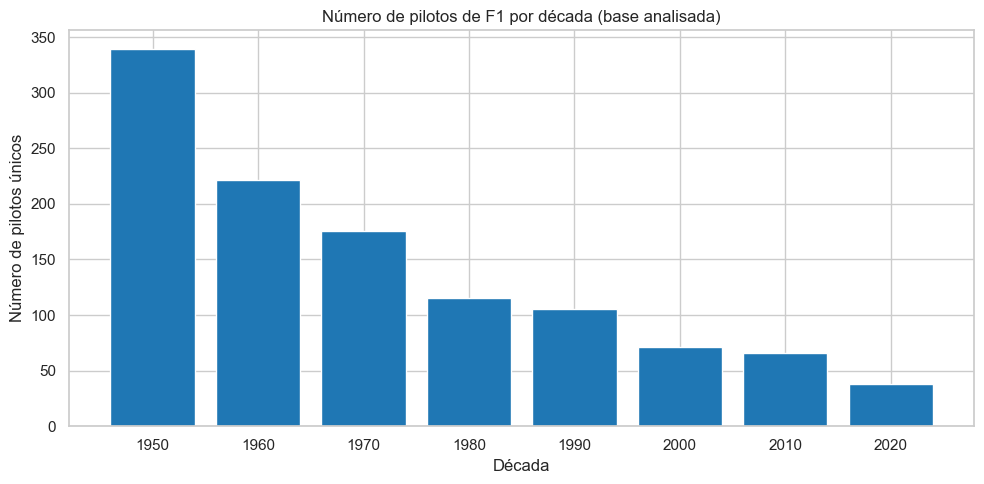

In [12]:
# Pilotos ativos por década
df_temporadas['Decada'] = (df_temporadas['Temporadas'] // 10) * 10

# Conta pilotos únicos por década
pilotos_por_decada = (
    df_temporadas.groupby('Decada')['Pilotos']
    .nunique()
    .sort_index()
)

plt.figure(figsize=(10,5))
plt.bar(pilotos_por_decada.index.astype(str), pilotos_por_decada.values, color='#1f77b4')
plt.xlabel('Década')
plt.ylabel('Número de pilotos únicos')
plt.title('Número de pilotos de F1 por década (base analisada)')
plt.tight_layout()
plt.show()

In [13]:
nacionalidades = df_analise['Nacionalidade_pt'].value_counts()
print(nacionalidades.head(10))

Nacionalidade_pt
Reino Unido           165
Estados Unidos        160
Itália                100
França                 73
Alemanha Ocidental     39
Brasil                 33
Argentina              26
Suíça                  24
Bélgica                23
África do Sul          23
Name: count, dtype: int64


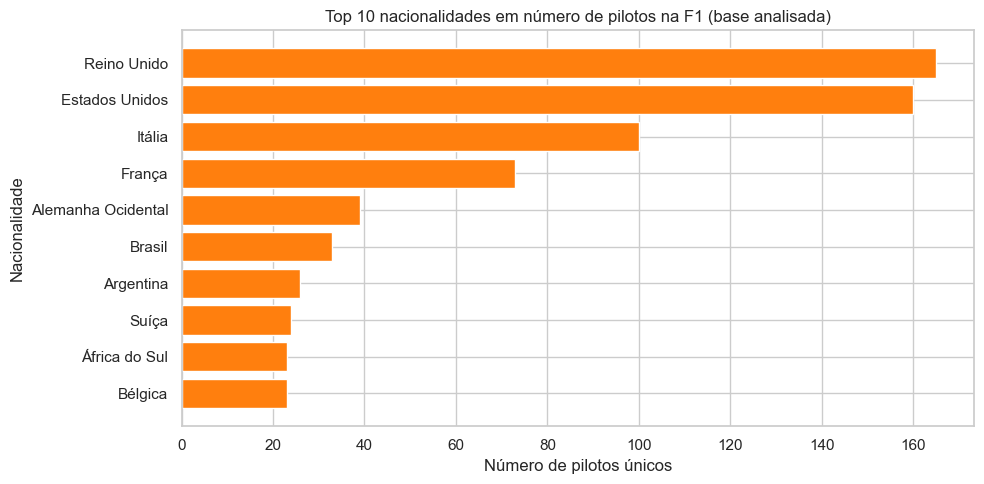

In [14]:
top_nac = (
    df_analise.groupby('Nacionalidade_pt')['Pilotos']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
plt.barh(top_nac.index, top_nac.values, color='#ff7f0e')
plt.gca().invert_yaxis()
plt.xlabel('Número de pilotos únicos')
plt.ylabel('Nacionalidade')
plt.title('Top 10 nacionalidades em número de pilotos na F1 (base analisada)')
plt.tight_layout()
plt.show()

#### 1. Número de acidentes por Circuito da Formula 1

In [15]:
acidentes_por_corrida = df_analise['Circuito'].value_counts()
print(acidentes_por_corrida)

Circuito
Indianapolis 500                     7
German Grand Prix                    5
Belgian Grand Prix                   3
Italian Grand Prix                   3
San Marino Grand Prix                2
Dutch Grand Prix                     2
South African Grand Prix             2
French Grand Prix                    2
United States Grand Prix             2
Natal Grand Prix                     1
Euroboss Series Season               1
Modena Grand Prix                    1
Shellsport Championship              1
Goodwood Festival Of Speed           1
Japanese Grand Prix                  1
Brdc International Trophy            1
World Championship Victory Race      1
Pau Grand Prix                       1
Monaco Grand Prix                    1
Nottingham Sportscar Club Meeting    1
Austrian Grand Prix                  1
Mexican Grand Prix                   1
Canadian Grand Prix                  1
Silver City Trophy                   1
Moroccan Grand Prix                  1
Name: count, dty

C:\Users\dudur\AppData\Local\Temp\ipykernel_30288\1442343843.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


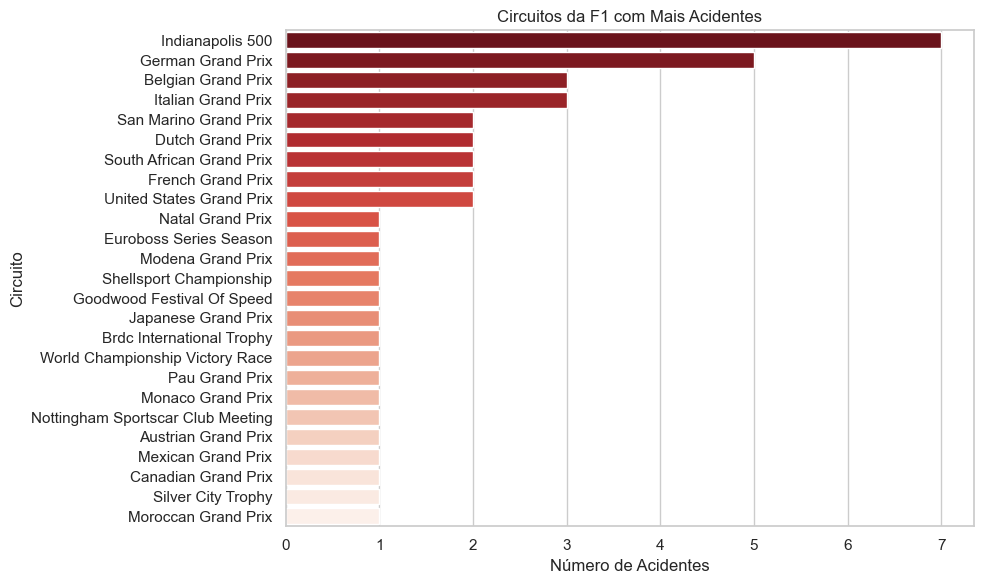

In [16]:
plt.figure(figsize=(10,6))
sns.barplot(
    x=acidentes_por_corrida.values,
    y=acidentes_por_corrida.index,
    palette='Reds_r'
)

plt.title('Circuitos da F1 com Mais Acidentes')
plt.xlabel('Número de Acidentes')
plt.ylabel('Circuito')
plt.tight_layout()
plt.show()

O circuito de Indianapolis fez parte do Campeonato Mundial de Fórmula 1 entre 1950 e 1960. Nesse período, 7 acidentes fatais ocorreram nessa pista. Isso faz do Indianapolis 500 o circuito mais letal da F1 no nosso recorte de dados, refletindo diferenças históricas e técnicas desse evento em relação ao restante do calendário.

#### 2. Equipes envolvidas em acidentes

In [17]:
equipes = df_fatais[df_fatais['Equipe'] != '']['Equipe'].value_counts()
print(equipes)

Equipe
Ferrari         7
Lotus           6
Kurtis Kraft    5
Cooper          5
Brabham         3
Marussia        2
Maserati        2
Shadow          2
Era             1
Williams        1
Cornis          1
Tyrrell         1
Porsche         1
Mcguire         1
Footwork        1
Honda           1
Surtees         1
Brm             1
Bmw             1
Kuzma           1
Penske          1
Alfa Romeo      1
De Tomaso       1
Osella          1
March           1
Simtek          1
Vanwall         1
Name: count, dtype: int64


C:\Users\dudur\AppData\Local\Temp\ipykernel_30288\1266912227.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


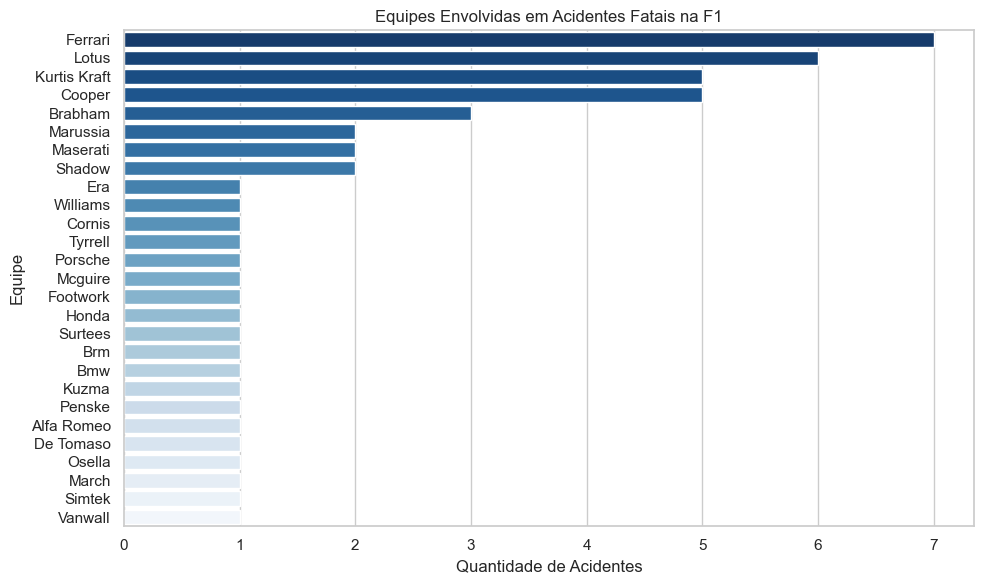

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(
    x=equipes.values, 
    y=equipes.index, 
    palette='Blues_r'
)
plt.title('Equipes Envolvidas em Acidentes Fatais na F1')
plt.xlabel('Quantidade de Acidentes')
plt.ylabel('Equipe')
plt.tight_layout()
plt.show()

Ferrari e Lotus lideram, com 7 e 6 acidentes fatais envolvendo pilotos respectivamente, como as equipes mais presentes em acidentes fatais da Fórmula 1 no período analisado.
No caso da Lotus, foram agrupadas suas principais variações de nome, como Lotus-Climax e Lotus-Ford.

#### 3. Número de pódios e participações em corridas de pilotos brasileiros

In [19]:
df_brasileiros = df_analise[df_analise['Nacionalidade_pt'] == 'Brasil']
total_participacoes = df_brasileiros['Participacao'].sum()
total_podios = df_brasileiros['Podio'].sum()
print(f"Total de participações: {total_participacoes}")
print(f"Total de pódios: {total_podios}")

Total de participações: 1981
Total de pódios: 293


In [20]:
top_podios = df_brasileiros[['Pilotos', 'Participacao', 'Podio']].sort_values(by='Podio', ascending=False)
print(top_podios)

                    Pilotos  Participacao  Podio
63             Ayrton Senna           162     80
766      Rubens Barrichello           326     68
622           Nelson Piquet           207     60
260            Felipe Massa           272     41
231      Emerson Fittipaldi           149     35
128             Carlos Pace            73      6
749          Roberto Moreno            77      1
582       Maurício Gugelmin            80      1
623       Nelson Piquet Jr.            28      1
29             Alex Ribeiro            20      0
168      Cristiano Da Matta            28      0
237        Enrique Bernoldi            29      0
148    Christian Fittipaldi            43      0
140             Chico Landi             6      0
141             Chico Serra            33      0
55         Antônio Pizzonia            20      0
118             Bruno Senna            46      0
377           Ingo Hoffmann             6      0
363  Hermano Da Silva Ramos             7      0
316             Gino

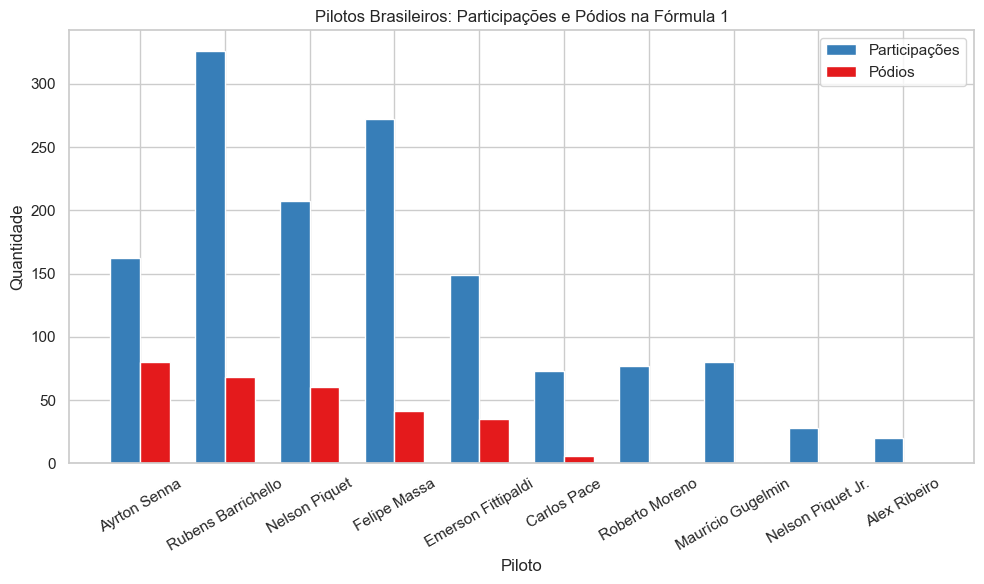

In [21]:
top_brasileiros = top_podios.head(10)

pilotos = top_brasileiros['Pilotos']
participacoes = top_brasileiros['Participacao']
podios = top_brasileiros['Podio']

x = np.arange(len(pilotos))
largura = 0.35

fig, ax = plt.subplots(figsize=(10,6))
b1 = ax.bar(x - largura/2, participacoes, largura, label='Participações', color='#377eb8')
b2 = ax.bar(x + largura/2, podios, largura, label='Pódios', color='#e41a1c')

# Personalizações
ax.set_ylabel('Quantidade')
ax.set_xlabel('Piloto')
ax.set_title('Pilotos Brasileiros: Participações e Pódios na Fórmula 1')
ax.set_xticks(x)
ax.set_xticklabels(pilotos, rotation=30)
ax.legend()
plt.tight_layout()
plt.show()

Os pilotos brasileiros com mais participações na história da Fórmula 1 são Rubens Barrichello, Felipe Massa, Nelson Piquet, Ayrton Senna e Emerson Fittipaldi.

E o Ayrton Senna lidera com mais pódios, seguido do Barrichello e do Piquet.

#### 4. Comparação da taxa de pódio e taxa de vitória para pilotos que foram campeões

In [22]:
champions = df_analise[df_analise['Campeao'] == 1].copy()
champions[['Pilotos', 'Vitorias', 'Podio', 'Largadas', 'Taxa_Vitoria', 'Taxa_podio']].sort_values(by='Taxa_Vitoria', ascending=False)

,Pilotos,Vitorias,Podio,Largadas,Taxa_Vitoria,Taxa_podio
485,Juan Manuel Fangio,24,35,51,0.46,0.67
17,Alberto Ascari,13,17,32,0.39,0.52
422,Jim Clark,25,32,72,0.34,0.44
592,Michael Schumacher,91,155,306,0.30,0.50
533,Lewis Hamilton,105,202,378,0.28,0.53
586,Max Verstappen,67,145,242,0.28,0.60
391,Jackie Stewart,27,43,99,0.27,0.43
10,Alain Prost,51,106,199,0.25,0.52
63,Ayrton Senna,41,80,161,0.25,0.49
171,Damon Hill,22,42,115,0.18,0.34


In [23]:
top15_campeoes = champions.sort_values(by='Taxa_Vitoria', ascending=False).head(15)

pilotos_campeoes = top15_campeoes['Pilotos']
taxa_vitoria = top15_campeoes['Taxa_Vitoria'] * 100
taxa_podio   = top15_campeoes['Taxa_podio'] * 100

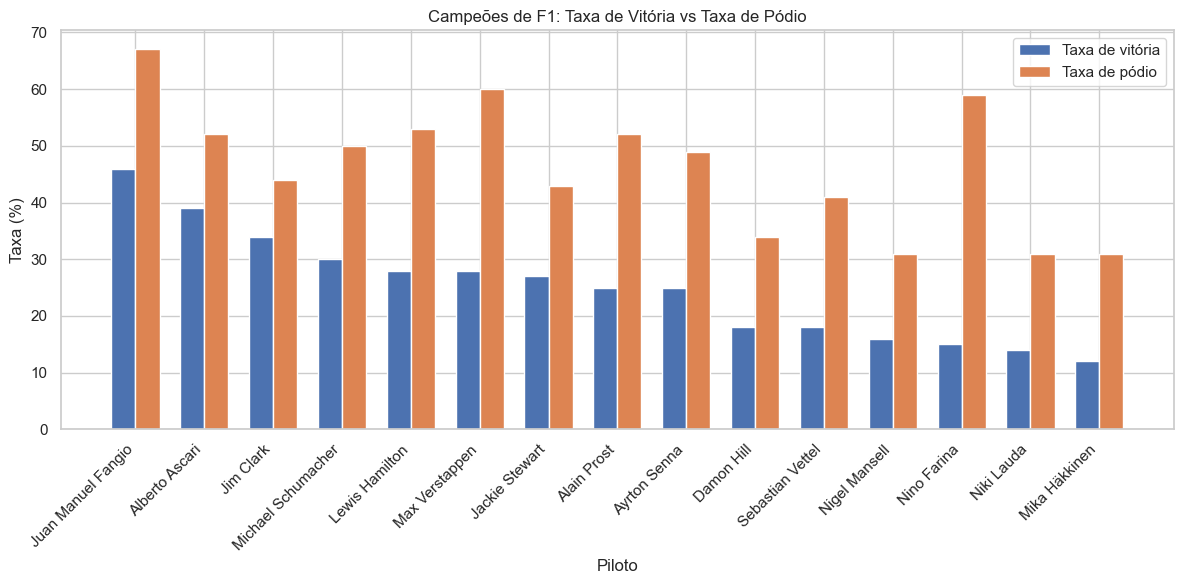

In [24]:
x = np.arange(len(pilotos_campeoes))
largura = 0.35

plt.figure(figsize=(12,6))

plt.bar(x - largura/2, taxa_vitoria, largura, label='Taxa de vitória')
plt.bar(x + largura/2, taxa_podio, largura, label='Taxa de pódio')

plt.title('Campeões de F1: Taxa de Vitória vs Taxa de Pódio')
plt.xlabel('Piloto')
plt.ylabel('Taxa (%)')
plt.xticks(x, pilotos_campeoes, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Entre os campeões mundiais, pilotos como Fangio, Ascari, Jim Clark, Schumacher, Hamilton e Verstappen apresentam as maiores taxas de vitória, vencendo de 25% a quase 50% das corridas que disputaram, enquanto nomes como Prost, Senna e Hamilton têm taxas de pódio ainda mais altas, evidenciando uma combinação de vitórias frequentes com enorme consistência em terminar entre os três primeiros.

Vale destacar Nino Farina, com quase 60% de pódio com uma das menores taxas de vitórias.

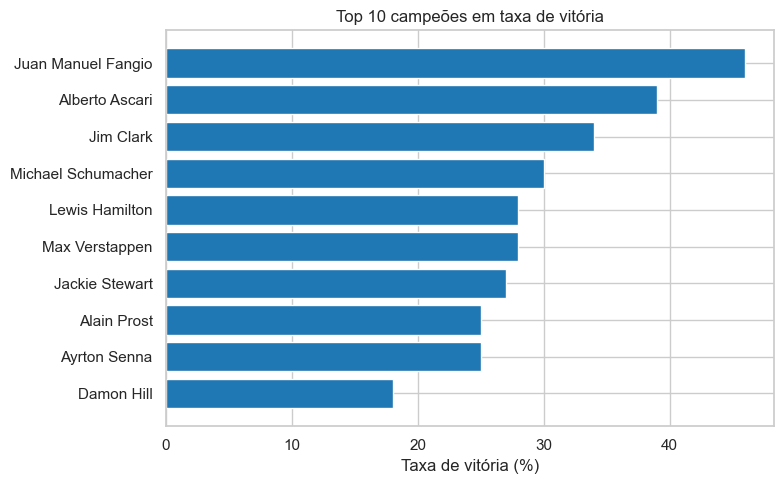

In [25]:
top_vitoria = champions.sort_values('Taxa_Vitoria', ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top_vitoria['Pilotos'], top_vitoria['Taxa_Vitoria']*100, color='#1f77b4')
plt.gca().invert_yaxis()
plt.xlabel('Taxa de vitória (%)')
plt.title('Top 10 campeões em taxa de vitória')
plt.tight_layout()
plt.show()

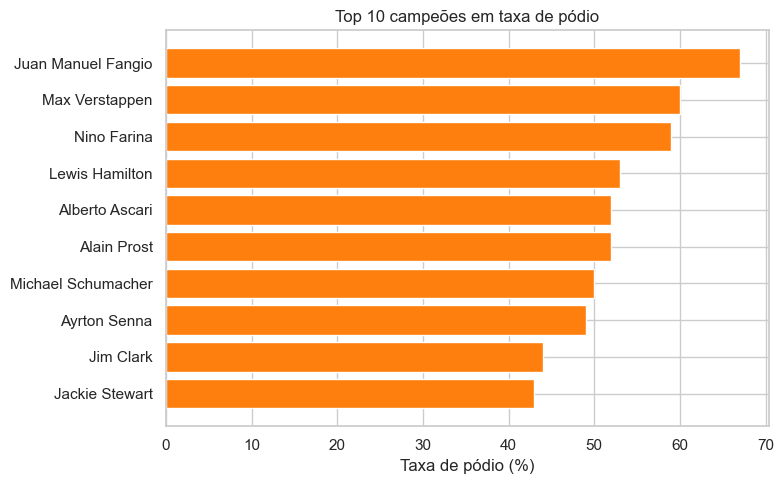

In [26]:
top_podio = champions.sort_values('Taxa_podio', ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top_podio['Pilotos'], top_podio['Taxa_podio']*100, color='#ff7f0e')
plt.gca().invert_yaxis()
plt.xlabel('Taxa de pódio (%)')
plt.title('Top 10 campeões em taxa de pódio')
plt.tight_layout()
plt.show()

#### 5. Pilotos com mais títulos e vitórias

In [27]:
# Filtrando apenas pilotos com pelo menos um título e Agrupando por pilotos e pegando o máximo de titulos e vitórias de cada um
resumo = df_analise[df_analise['Titulos'] > 0].groupby('Pilotos')[['Titulos', 'Vitorias']].max().sort_values(by=['Titulos','Vitorias'], ascending=False)
print(resumo)

                    Titulos  Vitorias
Pilotos                              
Lewis Hamilton            7       105
Michael Schumacher        7        91
Juan Manuel Fangio        5        24
Max Verstappen            4        67
Sebastian Vettel          4        53
Alain Prost               4        51
Ayrton Senna              3        41
Jackie Stewart            3        27
Niki Lauda                3        25
Nelson Piquet             3        23
Jack Brabham              3        14
Fernando Alonso           2        32
Jim Clark                 2        25
Mika Häkkinen             2        20
Emerson Fittipaldi        2        14
Graham Hill               2        14
Alberto Ascari            2        13
Nigel Mansell             1        31
Nico Rosberg              1        23
Damon Hill                1        22
Kimi Räikkönen            1        21
Jenson Button             1        15
Alan Jones                1        12
Mario Andretti            1        12
Jacques Vill

Lewis Hamilton e Schumacher estão empatados com 7 titulos mas Hamilton é o piloto mais vitorioso entre os campeões. Juan Manual Fangio conquistou 5 titulos com apenas 24 vitorias.

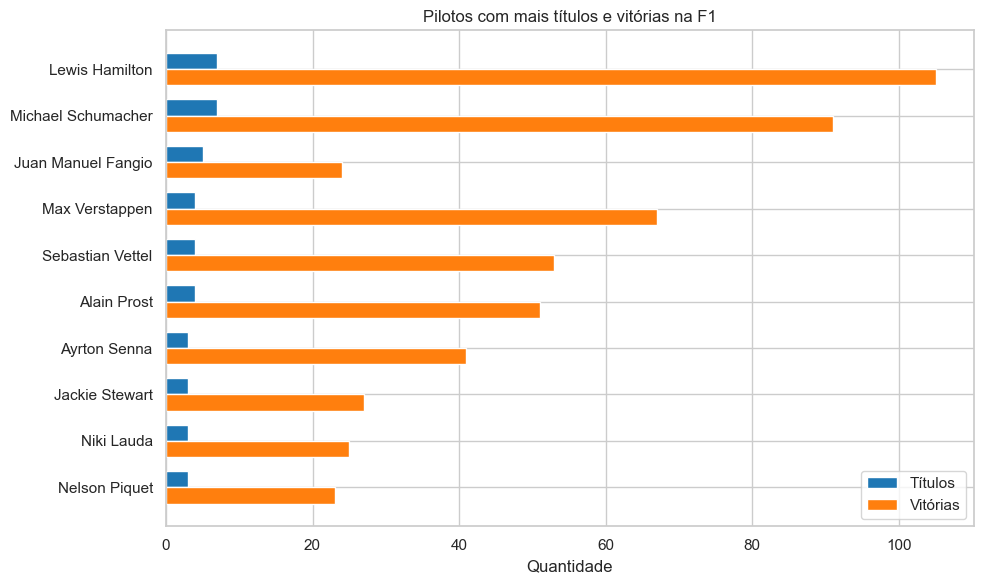

In [28]:
top = resumo.head(10).reset_index()

x = np.arange(len(top['Pilotos']))
larg = 0.35

plt.figure(figsize=(10,6))
plt.barh(x - larg/2, top['Titulos'], larg, label='Títulos', color='#1f77b4')
plt.barh(x + larg/2, top['Vitorias'], larg, label='Vitórias', color='#ff7f0e')

plt.yticks(x, top['Pilotos'])
plt.xlabel('Quantidade')
plt.title('Pilotos com mais títulos e vitórias na F1')
plt.legend()
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

#### 6. Pilotos com mais Poles e pontos

In [29]:
# Agrupando por pilotos e pegando a quantidade de poles e pontos
poles_pontos = df_analise.groupby('Pilotos')[['Pole_Positions', 'Pontos']].max()

In [30]:
# Trazendo apenas os 10 primeiros
poles_pontos = poles_pontos.sort_values(by=['Pole_Positions','Pontos'], ascending=False)
print(poles_pontos.head(10))

                    Pole_Positions  Pontos
Pilotos                                   
Lewis Hamilton                 104    5014
Michael Schumacher              68    1566
Ayrton Senna                    65     610
Sebastian Vettel                57    3098
Max Verstappen                  46    3029
Alain Prost                     33     768
Jim Clark                       33     255
Nigel Mansell                   32     480
Nico Rosberg                    30    1594
Juan Manuel Fangio              29     245


Lewis Hamilton lidera na história da F1 em pole positions (mais de 100) e também é o piloto com mais pontos acumulados na era moderna, seguido por Schumacher, Senna, Vettel e Verstappen. Estes números refletem tanto domínio em classificações quanto longevidade e performance em corridas.

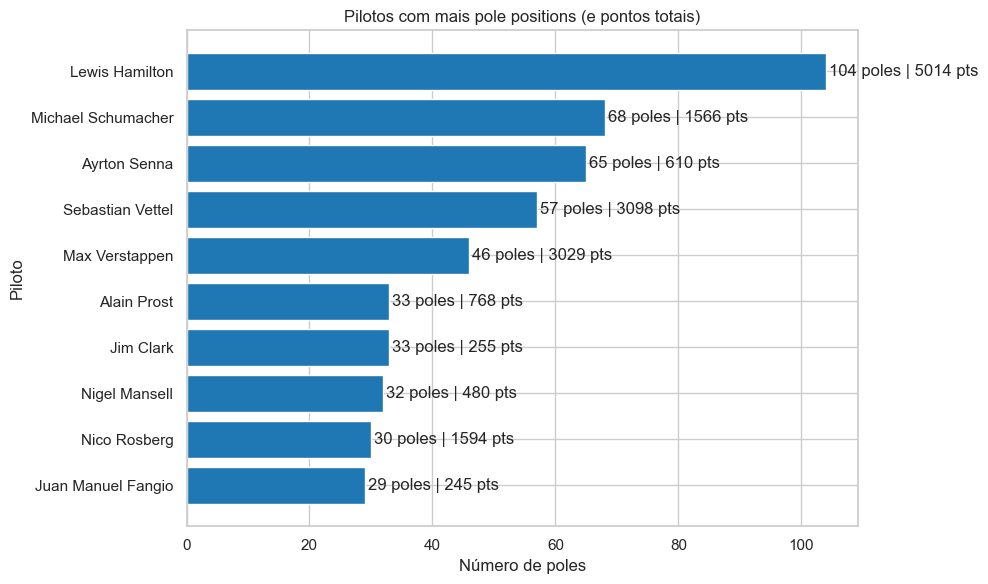

In [31]:
top10 = poles_pontos.head(10).reset_index()

plt.figure(figsize=(10,6))

plt.barh(top10['Pilotos'], top10['Pole_Positions'], color='#1f77b4')
plt.gca().invert_yaxis()

for i, (poles, pts) in enumerate(zip(top10['Pole_Positions'], top10['Pontos'])):
    plt.text(poles + 0.5, i, f"{int(poles)} poles | {int(pts)} pts", va='center')

plt.title('Pilotos com mais pole positions (e pontos totais)')
plt.xlabel('Número de poles')
plt.ylabel('Piloto')
plt.tight_layout()
plt.show()

#### 7. Taxa de pole positions e taxa de pódio por número de largadas

In [32]:
ranking_podio = df_analise[['Pilotos', 'Podio', 'Largadas', 'Taxa_podio']].sort_values('Taxa_podio', ascending=False)
print(ranking_podio.head(10))

                   Pilotos  Podio  Largadas  Taxa_podio
210        Dorino Serafini      1         1        1.00
546          Luigi Fagioli      6         7        0.86
485     Juan Manuel Fangio     35        51        0.67
586         Max Verstappen    145       242        0.60
634            Nino Farina     20        33        0.59
482  José Froilán González     15        26        0.58
533         Lewis Hamilton    202       378        0.53
17          Alberto Ascari     17        32        0.52
10             Alain Prost    106       199        0.52
772              Sam Hanks      4         8        0.50


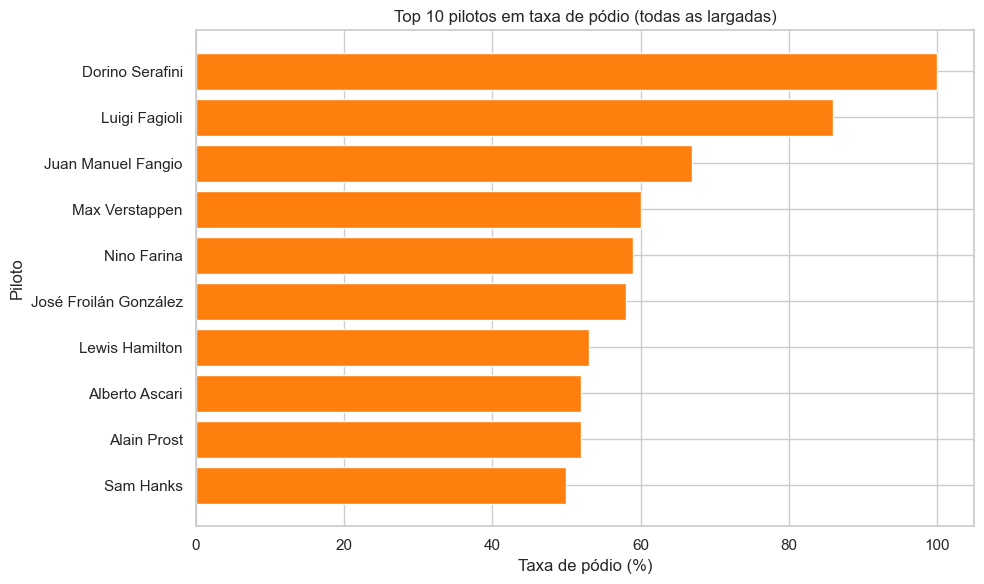

In [33]:
top10 = ranking_podio.head(10)
plt.figure(figsize=(10,6))
plt.barh(top10['Pilotos'], top10['Taxa_podio']*100, color='#ff7f0e')
plt.gca().invert_yaxis()
plt.xlabel('Taxa de pódio (%)')
plt.ylabel('Piloto')
plt.title('Top 10 pilotos em taxa de pódio (todas as largadas)')
plt.tight_layout()
plt.show()

O gráfico mostra que alguns pilotos têm 100% de taxa de pódio, como Dorino Serafini, que disputou apenas uma corrida e chegou em 2º lugar. Esses casos ilustram curiosidades estatísticas de amostras muito pequenas, enquanto nomes como Fangio, Hamilton ou Schumacher combinam alta taxa de pódio com grande número de largadas.

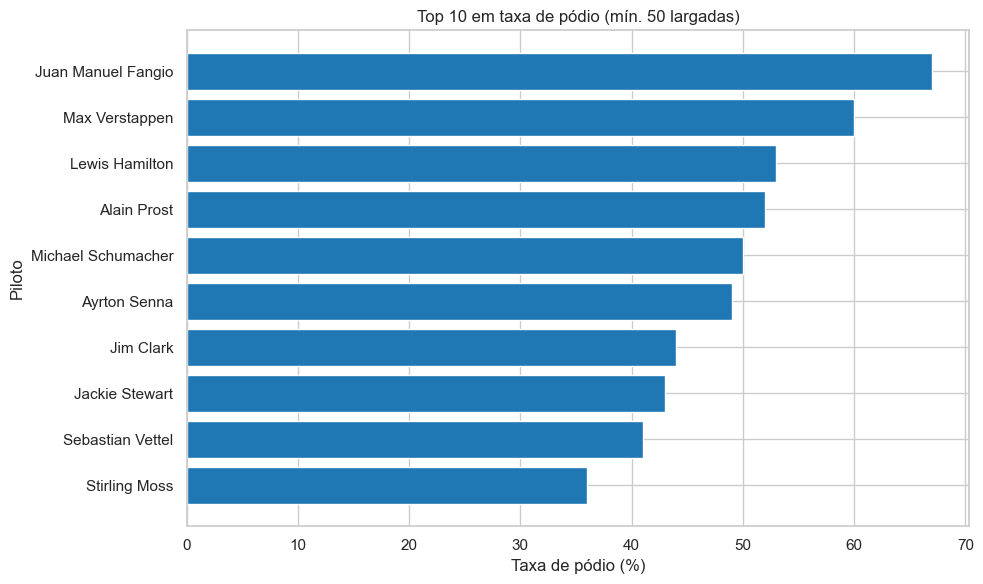

In [34]:
df_muito_ativos = df_analise[df_analise['Largadas'] >= 50].copy()
ranking_podio_ativos = df_muito_ativos.sort_values('Taxa_podio', ascending=False)
top10_ativos = ranking_podio_ativos.head(10)

plt.figure(figsize=(10,6))
plt.barh(top10_ativos['Pilotos'], top10_ativos['Taxa_podio']*100, color='#1f77b4')
plt.gca().invert_yaxis()
plt.xlabel('Taxa de pódio (%)')
plt.ylabel('Piloto')
plt.title('Top 10 em taxa de pódio (mín. 50 largadas)')
plt.tight_layout()
plt.show()

Enquanto alguns pilotos têm 100% de taxa em poucas largadas (como Serafini), entre os pilotos com longa carreira (50+ largadas), Fangio, Hamilton, Schumacher, Prost e Verstappen se destacam com taxas de pódio muito altas, mostrando domínio e consistência ao longo do tempo.

In [35]:
ranking_pole = df_analise[['Pilotos', 'Pole_Positions', 'Largadas', 'Taxa_pole']].sort_values('Taxa_pole', ascending=False)
print(ranking_pole.head(10))

                Pilotos  Pole_Positions  Largadas  Taxa_pole
485  Juan Manuel Fangio              29        51       0.56
422           Jim Clark              33        72       0.45
17       Alberto Ascari              14        32       0.42
63         Ayrton Senna              65       161       0.40
533      Lewis Hamilton             104       378       0.28
419          Jerry Hoyt               1         4       0.25
793       Stirling Moss              16        66       0.24
592  Michael Schumacher              68       306       0.22
215          Duke Nalon               1         3       0.20
586      Max Verstappen              46       242       0.19


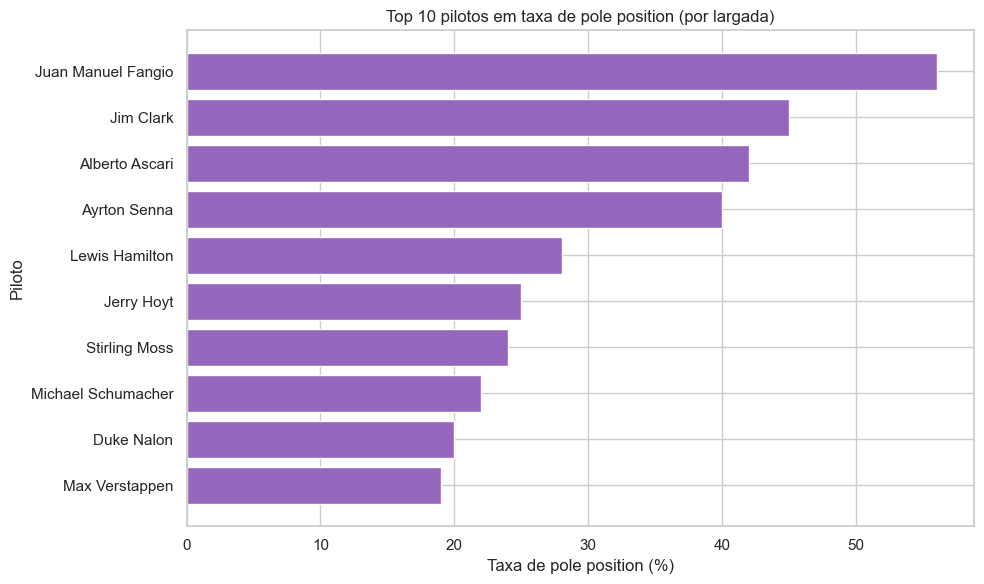

In [36]:
top_pole = ranking_pole.head(10)

plt.figure(figsize=(10,6))

plt.barh(top_pole['Pilotos'], top_pole['Taxa_pole']*100, color='#9467bd')
plt.gca().invert_yaxis()

plt.xlabel('Taxa de pole position (%)')
plt.ylabel('Piloto')
plt.title('Top 10 pilotos em taxa de pole position (por largada)')
plt.tight_layout()
plt.show()

Esse gráfico mostra quais campeões foram mais eficientes em classificação. Pilotos como Senna, Clark, Hamilton, Verstappen e outros combinam um número alto de poles com uma taxa de pole muito elevada por largada, o que evidencia domínio em volta rápida em suas épocas.

#### 8. Quantidade de acidentes fatais por evento da F1

In [37]:
acidentes_por_evento = df_eventos['Evento'].value_counts()
print(acidentes_por_evento)

Evento
Corrida              23
Treino livre         13
Teste                 7
Classificação         4
Teste pré-corrida     3
Demonstração          1
Name: count, dtype: int64


C:\Users\dudur\AppData\Local\Temp\ipykernel_30288\894048404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


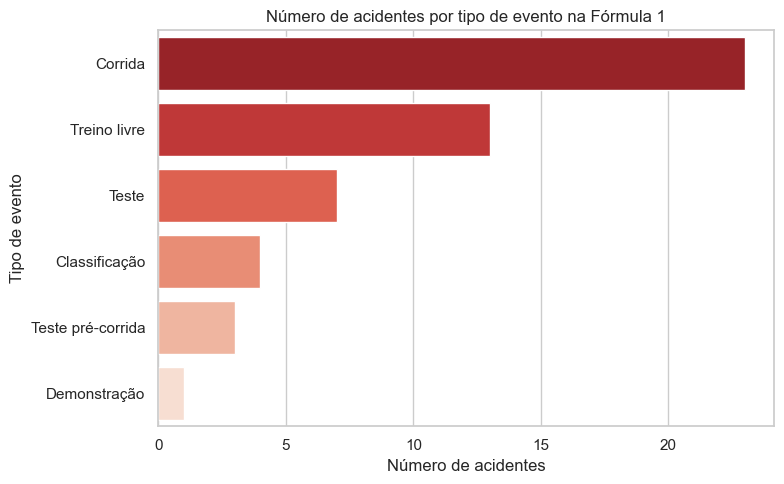

In [38]:
plt.figure(figsize=(8,5))

sns.barplot(
    x=acidentes_por_evento.values,
    y=acidentes_por_evento.index,
    palette='Reds_r'
)

plt.title('Número de acidentes por tipo de evento na Fórmula 1')
plt.xlabel('Número de acidentes')
plt.ylabel('Tipo de evento')
plt.tight_layout()
plt.show()

A maiorida dos acidentes fatais da Formula 1 ocorreu durante a corrida, mas uma parcela significativa também aconteceu em treinos, testes e sessões de classificação. Isso reforça que o risco está presente em todo o fim de semana, não apenas no domingo de prova.

### Exportar .csv

In [39]:
# Exportando cada um dos DF tratados para facilitar a montagem do Power BI
df_analise.to_csv('data/F1_base_pilotos.csv', index=False)
df_temporadas.to_csv('data/F1_base_temporadas.csv', index=False)
df_eventos.to_csv('data/F1_base_eventos.csv', index=False)
df_fatais.to_csv('data/F1_base_fatais.csv', index=False)
